Read Images
Analysed training data
Analysed testing data
Trained SVM
Predicted classes
Finished iteration
Analysed training data
Analysed testing data
Trained SVM
Predicted classes
Finished iteration
Analysed training data
Analysed testing data
Trained SVM
Predicted classes
Finished iteration
Analysed training data
Analysed testing data
Trained SVM
Predicted classes
Finished iteration
Analysed training data
Analysed testing data
Trained SVM
Predicted classes
Finished iteration
Analysed training data
Analysed testing data
Trained SVM
Predicted classes
Finished iteration
Analysed training data
Analysed testing data
Trained SVM
Predicted classes
Finished iteration
Analysed training data
Analysed testing data
Trained SVM
Predicted classes
Finished iteration
Analysed training data
Analysed testing data
Trained SVM
Predicted classes
Finished iteration
Analysed training data
Analysed testing data
Trained SVM
Predicted classes
Finished iteration


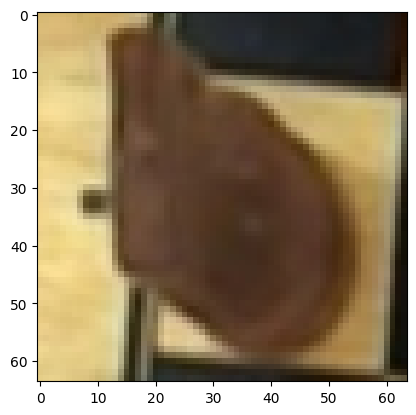

In [20]:
# Import required modules
import cv2
import numpy as np 
from matplotlib import pyplot as plt
import pickle
import os
import random
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold


%matplotlib inline 

# Extract images
wQueen = "chess_data\\wq\\"
bQueen = "chess_data\\bq\\"
wKing = "chess_data\\wk\\"
bKing = "chess_data\\bk\\"
wRook = "chess_data\\wr\\"
bRook = "chess_data\\br\\"
wBishop = "chess_data\\wb\\"
bBishop = "chess_data\\bb\\"
wPawn = "chess_data\\wp\\"
bPawn = "chess_data\\bp\\"
wKnight = "chess_data\\wn\\"
bKnight = "chess_data\\bn\\"

folders = [wQueen, bQueen, wKing, bKing, wRook, bRook, wBishop, bBishop, wPawn, bPawn, wKnight, bKnight]

# Generate labels
labels = ['White Queen', 'Black Queen', 'White King', 'Black King', 'White Rook', 'Black Rook', 'White Bishop', 'Black Bishop', 'White Pawn', 'Black Pawn', 'White Knight', 'Black Knight']

# Extract images and store
images = np.zeros([2221,64,64,3])
file_index = 0
label_array = []

for folder_index, folder in enumerate(folders):
    for image_index, filename in enumerate(os.listdir(folder)):
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if img is not None:
            label_array.append(labels[folder_index])
            img = cv2.resize(img,(64,64))
            images[file_index,:,:,:] = img
            file_index += 1

print('Read Images')

# Prepare evaluation metrics for storage across k-fold cross validation
svmcrossValAccuracy = []
svmcrossValF1 = []

svm_confusionMatrices = []

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform 10-fold cross-validation
for train_index, test_index in skf.split(images, label_array):
    # Split data into training and testing sets for this fold
    train_images, test_images = images[train_index], images[test_index]
    train_labels, test_labels = np.array(label_array)[train_index], np.array(label_array)[test_index]
    
    # Perform HOG feature extraction
    hog = cv2.HOGDescriptor(_winSize=(64,64),_blockSize=(32,32),_blockStride=(16,16),_cellSize=(16,16),_nbins=9)
    
    hog_features = np.zeros([len(train_labels),324])
    hog_features_test = np.zeros([len(test_labels),324])

    features = np.zeros([len(train_labels),580])
    features_test = np.zeros([len(test_labels),580])
    
    for i in range(0,len(train_labels)):
        image = train_images[i,:,:,:].astype(np.uint8)   
        center_region = image[16:48, 16:48]  # Central 32x32 region
        hog_feats = hog.compute(image).flatten()
        hog_features[i,:] = hog_feats
        # Convert to grayscale if the image is in color
        if len(center_region.shape) == 3 and center_region.shape[2] == 3:
            center_region_gray = cv2.cvtColor(center_region, cv2.COLOR_BGR2GRAY)
        else:
            center_region_gray = center_region
        # Calculate the grayscale histogram for the center region
        histogram = cv2.calcHist([center_region_gray], [0], None, [256], [0, 256]).flatten()
        histogram = cv2.normalize(histogram, histogram, norm_type=cv2.NORM_L1)
        features[i,:] = np.hstack([hog_feats, histogram])

    print('Analysed training data')

    plt.imshow(image)
    
    for i in range(0,len(test_labels)):
        image = test_images[i,:,:,:].astype(np.uint8)    
        center_region = image[16:48, 16:48]  # Central 32x32 region
        hog_feats = hog.compute(image).flatten()
        hog_features_test[i,:] = hog_feats
        if len(center_region.shape) == 3 and center_region.shape[2] == 3:
            center_region_gray = cv2.cvtColor(center_region, cv2.COLOR_BGR2GRAY)
        else:
            center_region_gray = center_region
        # Calculate the grayscale histogram for the center region
        histogram = cv2.calcHist([center_region_gray], [0], None, [256], [0, 256]).flatten()
        histogram = cv2.normalize(histogram, histogram, norm_type=cv2.NORM_L1)
        features_test[i,:] = np.hstack([hog_feats, histogram])

    print('Analysed testing data')
    
    # SVM
    
    # "X_train" is an array of training input data with dimensions (number of examples, number of features)
    # "y_train" is an array of corresponding training outputs (i.e. digit/class values). 
    
    # Initialise SVM model
    clf = sklearn.svm.SVC()
    
    # Train SVM model
    clf.fit(features, train_labels)

    print('Trained SVM')
    
    # Predict using testing data
    y_pred = clf.predict(features_test)

    print('Predicted classes')
    
    # Extract performance metrics
    svm_accuracy = sklearn.metrics.accuracy_score(test_labels, y_pred)
    svm_f1 = sklearn.metrics.f1_score(test_labels, y_pred,average='macro')

    svmcrossValAccuracy.append(svm_accuracy)
    svmcrossValF1.append(svm_f1)
    svm_confusion = sklearn.metrics.confusion_matrix(test_labels, y_pred)

    svm_confusionMatrices.append(svm_confusion)

    print('Finished iteration')

In [21]:
# Print SVM metrics

print(np.mean(svmcrossValAccuracy))
print(np.mean(svmcrossValF1))

0.7059810932008241
0.6146883688017454


In [22]:
import numpy as np

# Sum all confusion matrices
total_svm = np.sum(np.array(svm_confusionMatrices), axis=0)

# Find the average confusion matrix by dividing by the number of confusion matrices
svm_num_matrices = len(svm_confusionMatrices)
svm_average_confusion_matrix = total_svm / svm_num_matrices

# Convert to percentages by dividing each row by the sum of that row and multiplying by 100
svm_percentage_confusion_matrix = (svm_average_confusion_matrix.T / np.sum(svm_average_confusion_matrix, axis=1)).T * 100

print("Average Confusion Matrix (as percentages):")
print(svm_percentage_confusion_matrix)

# Save the trained SVM model
pickle.dump(clf, open('svm_rgb.pkl', 'wb'))


Average Confusion Matrix (as percentages):
[[72.02797203  0.          6.99300699  4.1958042   0.6993007  12.58741259
   0.6993007   0.          2.0979021   0.          0.          0.6993007 ]
 [22.5        27.5         5.          3.75        3.75       23.75
   1.25        1.25        2.5         0.          5.          3.75      ]
 [ 9.02777778  0.         78.47222222  0.          0.          4.86111111
   0.69444444  0.          2.77777778  0.          1.38888889  2.77777778]
 [ 8.33333333  0.          1.38888889 81.25        0.          5.55555556
   0.          0.          0.          0.          0.          3.47222222]
 [26.98412698 15.87301587  7.93650794  6.34920635  4.76190476 26.98412698
   0.          0.          0.          0.          7.93650794  3.17460317]
 [11.88811189  0.          4.1958042   2.0979021   0.         72.02797203
   0.6993007   0.          1.3986014   0.6993007   2.7972028   4.1958042 ]
 [ 0.          0.          0.          0.          0.          0.
  8

In [19]:
print(svm_confusionMatrices)

[array([[ 9,  0,  0,  1,  0,  4,  0,  0,  0,  0,  0,  0],
       [ 2,  2,  1,  0,  0,  1,  0,  0,  1,  0,  1,  0],
       [ 0,  0, 14,  0,  0,  0,  0,  0,  1,  0,  0,  0],
       [ 1,  0,  0, 13,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 2,  1,  0,  0,  0,  3,  0,  0,  0,  0,  0,  0],
       [ 4,  0,  0,  0,  0,  9,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 32,  0,  4,  0,  1,  1],
       [ 0,  0,  0,  0,  0,  0,  2,  2,  4,  0,  1,  2],
       [ 0,  0,  0,  0,  0,  0,  1,  0, 27,  1,  2,  2],
       [ 0,  0,  0,  0,  0,  0,  2,  0,  1, 11,  0,  2],
       [ 0,  0,  0,  0,  0,  0,  4,  0,  1,  0, 13,  1],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  2,  1,  1, 29]], dtype=int64), array([[14,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  2,  1,  2,  0,  2,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 12,  0,  0,  1,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  1, 11,  0,  1,  0,  0,  0,  0,  0,  2],
       [ 3,  1,  1,  0,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 3,  0,

In [25]:
import pandas as pd
import numpy as np

# Your confusion matrix
conf_matrix = np.array([
    [72.02797203, 0.0, 6.99300699, 4.1958042, 0.6993007, 12.58741259, 0.6993007, 0.0, 2.0979021, 0.0, 0.0, 0.6993007],
    [22.5, 27.5, 5.0, 3.75, 3.75, 23.75, 1.25, 1.25, 2.5, 0.0, 5.0, 3.75],
    [9.02777778, 0.0, 78.47222222, 0.0, 0.0, 4.86111111, 0.69444444, 0.0, 2.77777778, 0.0, 1.38888889, 2.77777778],
    [8.33333333, 0.0, 1.38888889, 81.25, 0.0, 5.55555556, 0.0, 0.0, 0.0, 0.0, 0.0, 3.47222222],
    [26.98412698, 15.87301587, 7.93650794, 6.34920635, 4.76190476, 26.98412698, 0.0, 0.0, 0.0, 0.0, 7.93650794, 3.17460317],
    [11.88811189, 0.0, 4.1958042, 2.0979021, 0.0, 72.02797203, 0.6993007, 0.0, 1.3986014, 0.6993007, 2.7972028, 4.1958042],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 88.85941645, 0.0, 5.57029178, 2.12201592, 1.06100796, 2.3872679],
    [0.0, 0.0, 0.9009009, 0.0, 0.0, 0.0, 31.53153153, 28.82882883, 12.61261261, 1.8018018, 12.61261261, 11.71171171],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.67664671, 0.0, 78.14371257, 2.09580838, 3.29341317, 4.79041916],
    [0.0, 0.0, 0.0, 1.21212121, 0.0, 0.0, 10.3030303, 0.0, 6.06060606, 64.24242424, 1.21212121, 16.96969697],
    [0.0, 0.0, 0.54347826, 0.0, 0.0, 0.0, 20.65217391, 2.7173913, 8.69565217, 1.63043478, 52.7173913, 13.04347826],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.50750751, 0.0, 4.8048048, 2.7027027, 2.1021021, 82.88288288]
])

# Define the custom labels
labels = ['wq', 'bq', 'wk', 'bk', 'wr', 'br', 'wb', 'bb', 'wp', 'bp', 'wn', 'bn']

# Create a DataFrame with custom labels
df = pd.DataFrame(conf_matrix, columns=labels, index=labels)
df = df.round(2)  # Round to two decimal places

# Display the formatted confusion matrix
df


,wq,bq,wk,bk,wr,br,wb,bb,wp,bp,wn,bn
wq,72.03,0.00,6.99,4.20,0.70,12.59,0.70,0.00,2.10,0.00,0.00,0.70
bq,22.50,27.50,5.00,3.75,3.75,23.75,1.25,1.25,2.50,0.00,5.00,3.75
wk,9.03,0.00,78.47,0.00,0.00,4.86,0.69,0.00,2.78,0.00,1.39,2.78
bk,8.33,0.00,1.39,81.25,0.00,5.56,0.00,0.00,0.00,0.00,0.00,3.47
wr,26.98,15.87,7.94,6.35,4.76,26.98,0.00,0.00,0.00,0.00,7.94,3.17
br,11.89,0.00,4.20,2.10,0.00,72.03,0.70,0.00,1.40,0.70,2.80,4.20
wb,0.00,0.00,0.00,0.00,0.00,0.00,88.86,0.00,5.57,2.12,1.06,2.39
bb,0.00,0.00,0.90,0.00,0.00,0.00,31.53,28.83,12.61,1.80,12.61,11.71
wp,0.00,0.00,0.00,0.00,0.00,0.00,11.68,0.00,78.14,2.10,3.29,4.79
bp,0.00,0.00,0.00,1.21,0.00,0.00,10.30,0.00,6.06,64.24,1.21,16.97


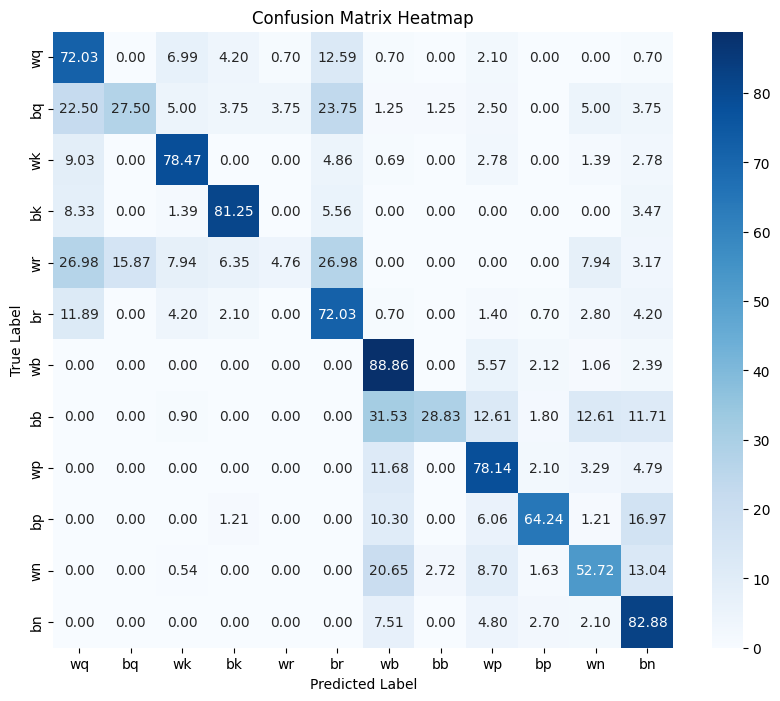

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels)

# Add labels and title
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()
